In [1]:
from astropy.cosmology import LambdaCDM,FlatLambdaCDM,wCDM,FlatwCDM,w0waCDM
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from jax import random,grad, jit
import matplotlib.pyplot as pl
import jax.numpy as jnp
import jax_cosmo as jc
import scipy.sparse
import numpy as np
import numpyro
import sys
import jax

sys.path.append('/Users/hollowayp/zBEAMS')
default_cosmo = jc.Cosmology(Omega_c=0.3,
                            h=0.7,
                            Omega_k=0,
                            w0=-1,
                            Omega_b=0,
                            wa=0,
                            sigma8=0.8,
                            n_s=0.96)

In [3]:
from cosmology_JAX import j_r_SL

In [ ]:
def j_likelihood_SL(zL_obs,zS_obs,r_obs,sigma_r_obs,cosmo_type):
    s8 = 0.8;n_s = 0.96;Ob=0#Putting all the matter in dark-matter (doesn't make a difference)
    '''
    NEED TO CHECK WHAT ON EARTH THIS KEY IS???
    '''
    key = jax.random.PRNGKey(0)
    zL_scatter = 0.01;zS_scatter = 0.01
    zL = numpyro.sample('zL',dist.TruncatedNormal(jnp.array(zL_obs),zL_scatter,low=0),sample_shape=(1,)).flatten()
    zS = numpyro.sample('zS',dist.TruncatedNormal(jnp.array(zS_obs),zS_scatter,low=0),sample_shape=(1,)).flatten()

    OM = jnp.squeeze(numpyro.sample("OM", dist.Uniform(0,1),sample_shape=(1,)))#(len(zL_obs),1))
    Ode = jnp.squeeze(numpyro.sample("Ode", dist.Uniform(0,1),sample_shape=(1,)))#(len(zL_obs),1))
    H0= 70
    if cosmo_type in ['FlatLambdaCDM','FlatwCDM']:
        print('Assuming a flat universe')
        Ok = 0 #Somehow this bugs?? 
    else:
        print('Assuming the universe may have curvature')
        Ok = jnp.squeeze(numpyro.sample("Ok", dist.Uniform(-1,1),sample_shape=(1,)))#(len(zL_obs),1))
    if cosmo_type in ['LambdaCDM','FlatLambdaCDM']:
        print('Assuming universe has a cosmological constant')
        w = -1.0
        wa = 0.0
    else:
        print('Assuming non-trivial dark energy equation of state')
        w = jnp.squeeze(numpyro.sample("w", dist.Uniform(-6,4),sample_shape=(1,))) #Physicality constraints
        wa = jnp.squeeze(numpyro.sample("wa", dist.Uniform(-3,1),sample_shape=(1,))) 
    '''
    If this code turns out to be quite slow, the previous likelihood function used interpolation.
    '''
    if cosmo_type == 'FlatLambdaCDM': cosmo = jc.Cosmology(Omega_c=OM,h=H0/100, Omega_k=0,w0=w,
                                        Omega_b=Ob,wa=wa,sigma8=s8,n_s=n_s)
    if cosmo_type == 'LambdaCDM': cosmo = jc.Cosmology(Omega_c=OM,h=H0/100, Omega_k=(1-(OM+Ode)),w0=w,
                                        Omega_b=Ob,wa=wa,sigma8=s8,n_s=n_s)
    if cosmo_type == 'FlatwCDM': cosmo = jc.Cosmology(Omega_c=OM,h=H0/100, Omega_k=0,w0=w,
                                        Omega_b=Ob,wa=wa,sigma8=s8,n_s=n_s)
    if cosmo_type == 'wCDM': cosmo = jc.Cosmology(Omega_c=OM,h=H0/100, Omega_k=(1-(OM+Ode)),w0=w,
                                         Omega_b=Ob,wa=wa,sigma8=s8,n_s=n_s)
    r_theory = j_r_SL(zL,zS,cosmo) 
    numpyro.sample("r", dist.Normal(r_theory, sigma_r_obs), obs=r_obs)

sampler = infer.MCMC(
    infer.NUTS(j_likelihood_SL),
    num_warmup=200,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
)

N_obs = 1000
zL_obs = jnp.array(scipy.stats.uniform(0.1,0.5).rvs(size=N_obs))
zS_obs = jnp.array(scipy.stats.uniform(0.5,1.0).rvs(size=N_obs))
sigma_r_obs = 0.01
r_obs = jnp.array(scipy.stats.norm(loc=1,scale=sigma_r_obs).rvs(size=N_obs)*j_r_SL(zL_obs,zS_obs,default_cosmo))

sampler.run(jax.random.PRNGKey(0),
            zL_obs=zL_obs,
            zS_obs=zS_obs,
            r_obs=r_obs,
            sigma_r_obs=sigma_r_obs,
            cosmo_type='wCDM')

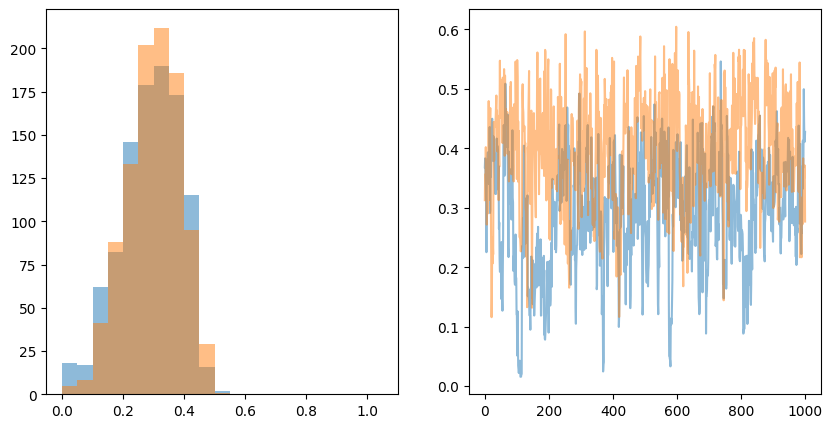

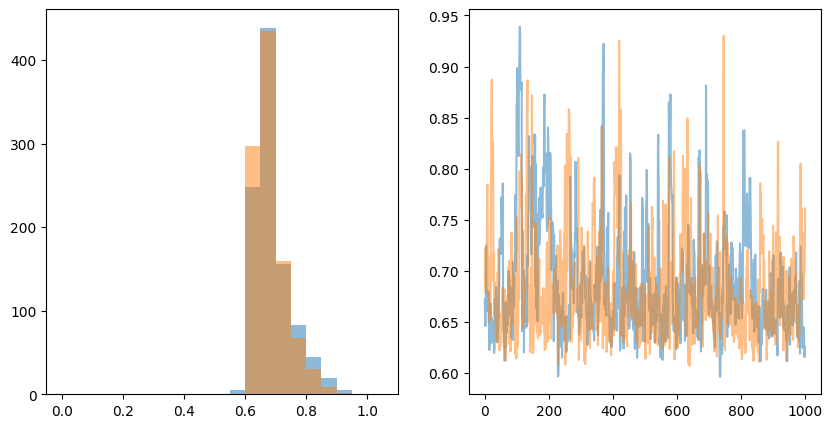

0.6865135


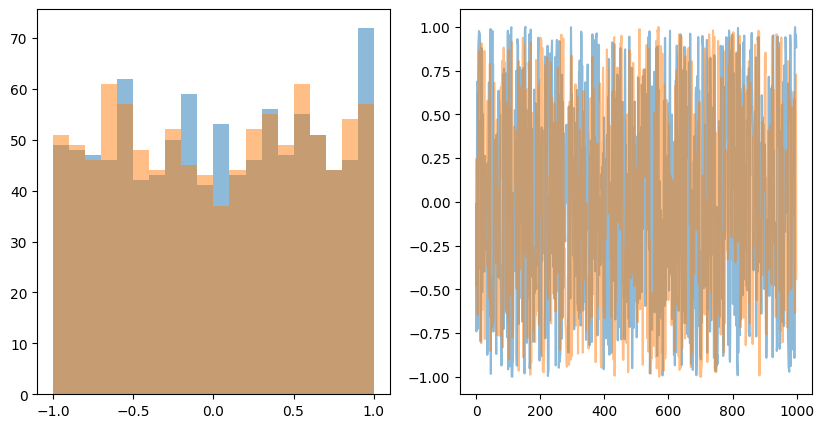

0.013471541


In [8]:
prop = 'OM'

fig,ax = pl.subplots(1,2,figsize=(10,5))
for i in range(2):
    ax[0].hist(sampler.get_samples(group_by_chain=True)['OM'][i,:,0],alpha=0.5,bins=np.arange(0,1.1,0.05))
    ax[1].plot(0.1*i+sampler.get_samples(group_by_chain=True)['OM'][i,:,0],alpha=0.5)
    
pl.show()

fig,ax = pl.subplots(1,2,figsize=(10,5))
for i in range(2):
    ax[0].hist(sampler.get_samples(group_by_chain=True)['Ode'][i,:,0],alpha=0.5,bins=np.arange(0,1.1,0.05))
    ax[1].plot(sampler.get_samples(group_by_chain=True)['Ode'][i,:,0],alpha=0.5)
    
pl.show()
print(np.mean(sampler.get_samples()['Ode']))

fig,ax = pl.subplots(1,2,figsize=(10,5))
for i in range(2):
    ax[0].hist(sampler.get_samples(group_by_chain=True)['Ok'][i,:,0],alpha=0.5,bins=np.arange(-1,1.1,0.1))
    ax[1].plot(sampler.get_samples(group_by_chain=True)['Ok'][i,:,0],alpha=0.5)
    
pl.show()
print(np.mean(sampler.get_samples()['Ok']))
